In [14]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple,deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
env=gym.make("LunarLander-v3",continuous=False,gravity=-10.0,enable_wind=False)

In [15]:
is_python='inline' in matplotlib.get_backend()
if is_python:
    from IPython import display
plt.ion()
device=torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


In [16]:
Transition=namedtuple('Transition',('state','action','next_state','reward'))

class ReplayMemory(object):
    def __init__(self,capacity):
        self.memory=deque([],maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    def  __len__(self):
        return len(self.memory)

In [17]:
class DQN(nn.Module):
    def __init__(self,n_observation,n_actions):
        super(DQN,self).__init__()
        self.l1=nn.Linear(n_observation,128)
        self.l2=nn.Linear(128,128)
        self.l3=nn.Linear(128,n_actions)
        
    def forward(self,x):
        x=F.relu(self.l1(x))
        x=F.relu(self.l2(x))
        return self.l3(x)
    
    

In [18]:
batch_size=128
gamma=0.99
eps_start=0.9
eps_end=0.05
eps_decay=1000
tau=0.005
lr=1e-4

In [19]:
n_actions=env.action_space.n
state,info=env.reset()
n_observation=len(state)
policy_net=DQN(n_observation,n_actions).to(device)
target_net=DQN(n_observation,n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimiser=optim.AdamW(policy_net.parameters(),lr=lr,amsgrad=True)
memory=ReplayMemory(10000)


In [20]:
steps_done=0
def select_action(state):
    global steps_done
    sample=random.random()
    eps_threshold=eps_end+(eps_start-eps_end)* math.exp(-1*steps_done/eps_decay)
    steps_done+=1
    if sample>eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]],device=device,dtype=torch.long)


        
    

In [21]:
episode_duration=[]
def plot_duration(show_result=False):
    plt.figure(1)
    duration_t=torch.tensor(episode_duration,dtype=torch.float)
    if show_result:
        plt.title('result')
    else:
        plt.clf()
        plt.title('Training..')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(duration_t.numpy())
    
    if len(duration_t)>=100:
        means=duration_t.unfold(0,100,1).mean(1).view(-1)
        means=torch.cat((torch.zeros(99),means))
        plt.plot(means.numpy())
        
    plt.pause(0.001)
    if is_python:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
            
        
        
    

In [22]:
def optimise_model():
    if len(memory)<batch_size:
        return
    transition=memory.sample(batch_size)
    batch=Transition(*zip(*transition))
    non_final_mask=torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)),device=device,dtype=torch.bool)
    non_final_next_states=torch.cat([s for s in batch.next_state if s is not None])
    state_batch=torch.cat(batch.state)
    action_batch=torch.cat(batch.action)
    reward_batch=torch.cat(batch.reward)
    
    state_action_values=policy_net(state_batch).gather(1,action_batch)
    next_state_values=torch.zeros(batch_size,device=device)
    with torch.no_grad():
        next_state_values[non_final_mask]=target_net(non_final_next_states).max(1).values
    expected_state_action_values=(next_state_values*gamma)+reward_batch
    criterion=nn.SmoothL1Loss()
    loss=criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    
    optimiser.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(),100)
    optimiser.step()
    
        

Complete


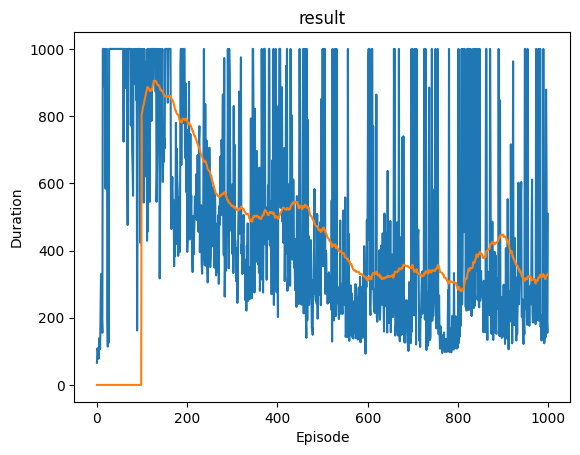

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [23]:
num_episodes=1000

for i in range(num_episodes):
    state,info=env.reset()
    state=torch.tensor(state,dtype=torch.float32,device=device).unsqueeze(0)
    for t in count():
        action=select_action(state)
        observation,reward,terminated,truncated,_=env.step(action.item())
        reward=torch.tensor([reward],device=device)
        done=terminated or truncated
        if terminated:
            next_state=None
        else:
            next_state=torch.tensor(observation,dtype=torch.float32,device=device).unsqueeze(0)
            
        memory.push(state,action,next_state,reward)
        
        state=next_state
        optimise_model()
        target_net_state_dict=target_net.state_dict()
        policy_net_state_dict=policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key]=policy_net_state_dict[key]*tau+target_net_state_dict[key]*(1-tau)
        target_net.load_state_dict(target_net_state_dict)
        if done:
            episode_duration.append(t+1)
            plot_duration()
            break
print("Complete")        
plot_duration(show_result=True)
plt.ioff()
plt.show()
            
        
        

In [26]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        state_tensor=torch.tensor(state,dtype=torch.float32,device=device).unsqueeze(0)
        action = select_action((state_tensor))
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(policy_net, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
